# Normalizing flows in PyTorch (part 3)
## Flows in variational inference

The implementation of *Normalizing Flows* [[1](#reference1),[2](#reference)] based on `torch.distributions` that we saw in the two previous tutorials was intentionnaly constrained to toy examples, where we only optimized the transform from a Gaussian to different given *target densities*. However, flows come in very handy in several probabilistic inference mecanisms, and notably in *variational inference*. The main idea is still to *transform* a simple probability distribution through a sequence of invertible nonlinear transforms. However, this optimization will be part of a larger scheme of probabilistic inference. 

In this tutorial we will cover
1. A [quick recap](#recap) of the concepts previously introduced (smaller than before)
2. A fast introduction to [Variational Auto-Encoders](#vae)
3. An explanation of how [normalizing flows improve VAEs](#nf) and how to implement it
4. Some [modifications and tips to improve reconstruction](#improve) while combining NFs and VAEs

**Note**: Once again, this tutorial is a work-in-progress, so I would gladly take any feedback, update or suggestions. If you have any ideas, please contact me (https://esling.github.io/)

<a id="recap"></a>
## Quick recap

### Normalizing flows

Normalizing flows allow to transform a probability distribution, through a series of *change of variable*. If we start with a random vector $\mathbf{z}_0$ with distribution $q_0$, we can apply a series of mappings $f_i$, $i \in 1,\cdots,k$ with $k\in\mathcal{N}^{+}$ and obtain a normalizing flow. If we apply $k$ normalizing flows, the distribution of $\mathbf{z}_k\sim q_k(\mathbf{z}_k)$ in log-probability will be given by

$$
\text{log} q_K(\mathbf{z}_k) = \text{log} q_0(\mathbf{z}_0) - \sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right| 
\tag{1}
$$

Of course, we can perform any amount of combined transformations.

### PyTorch distributions

We still rely on the novel [PyTorch distributions module](https://pytorch.org/docs/stable/_modules/torch/distributions/), which is defined in `torch.distributions`.

In [40]:
%pylab inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
import matplotlib.animation as animation
matplotlib.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
from IPython.display import HTML
# Imports for plotting
import numpy as np
import matplotlib.pyplot as plt
# Define grids of points (for later plots)
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

Populating the interactive namespace from numpy and matplotlib


### Optimizing normalizing flows

The main interest in normalizing flows is that we could optimize the parameters of these flow in order to fit complex and rich probability distributions. In order to perform *inference*, we had to deal with the fact that the `Transform` object is not inherently parametric. To do so, we define our own `Flow` class which can be seen both as a `Transform` and also a `Module`that can be optmized

In [41]:
class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

Based on this minimal class, we defined a wide variety of flows in the previous tutorials, but we will here simply reuse the *planar* and *radial* flows. Therefore, we redefine here the `PlanarFlow` and `RadialFlow` classes.

In [42]:
class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.init_parameters()

    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)
    
class RadialFlow(Flow):

    def __init__(self, dim):
        super(RadialFlow, self).__init__()
        self.z0 = nn.Parameter(torch.Tensor(1, dim))
        self.alpha = nn.Parameter(torch.Tensor(1))
        self.beta = nn.Parameter(torch.Tensor(1))
        self.dim = dim
        self.init_parameters()

    def _call(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        return z + (self.beta * h * (z - self.z0))

    def log_abs_det_jacobian(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        hp = - 1 / (self.alpha + r) ** 2
        bh = self.beta * h
        det_grad = ((1 + bh) ** self.dim - 1) * (1 + bh + self.beta * hp * r)
        return torch.log(det_grad.abs() + 1e-9)

Now in order to define a sequence of such flows, we defined a `NormalizingFlow` class, which is responsible for applying a series of flows and recording their determinant

In [43]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det

<a id="vae"></a>
## Variational auto-encoders

An exhaustive explanation on Variational Auto-Encoders (VAEs) is out of the scope of this tutorial, so refer to the original papers [[3](#reference1),[4](#reference)] for a complete understanding. Briefly, VAEs are generative models aiming to find the underlying probability distribution of the data $p(\mathbf{x})$ based on a set of examples in $\mathbf{x}\in\mathbb{R}^{d_{x}}$. To do so, we consider *latent variables* defined in a lower-dimensional space $\mathbf{z}\in\mathbb{R}^{d_{z}}$ ($d_{z} \ll d_{x}$) with the joint probability distribution $p(\mathbf{x}, \mathbf{z}) = p(\mathbf{x} \vert \mathbf{z})p(\mathbf{z})$. Unfortunately, for complex distributions this integral is too complex and cannot be found in closed form.



### Variational inference

The idea of *variational inference* (VI) allows to solve this problem through *optimization* by assuming a simpler approximate distribution $q_{\phi}(\mathbf{z}\vert\mathbf{x})\in\mathcal{Q}$ from a family $\mathcal{Q}$ of approximate densities. Hence, the goal is to minimize the difference between this approximation and the real distribution. Therefore, this turns into the optimization problem of minimizing the Kullback-Leibler (KL) divergence between the parametric approximation and the original density

$$
q_{\phi}^{*}(\mathbf{z}\vert \mathbf{x})=\text{argmin}_{q_{\phi}(\mathbf{z} \vert \mathbf{x})\in\mathcal{Q}} \mathcal{D}_{KL} \big[ q_{\phi}\left(\mathbf{z} \vert \mathbf{x}\right) \parallel p\left(\mathbf{z} \vert \mathbf{x}\right) \big]
\tag{2}
$$

By developing this KL divergence and re-arranging terms (the detailed development can be found in [3](#reference1)), we obtain

$$
\log{p(\mathbf{x})} - D_{KL} \big[ q_{\phi}(\mathbf{z} \vert \mathbf{x}) \parallel p(\mathbf{z} \vert \mathbf{x}) \big] =
\mathbb{E}_{\mathbf{z}} \big[ \log{p(\mathbf{x} \vert \mathbf{z})}\big] - D_{KL} \big[ q_{\phi}(\mathbf{z} \vert \mathbf{x}) \parallel p(\mathbf{z}) \big]
\tag{3}
$$

This formulation describes the quantity we want to maximize $\log p(\mathbf{x})$ minus the error we make by using an approximate $q$ instead of $p$. Therefore, we can optimize this alternative objective, called the *evidence lower bound* (ELBO)

$$
\begin{equation}
\mathcal{L}_{\theta, \phi} = \mathbb{E} \big[ \log{ p_\theta (\mathbf{x|z}) } \big] - \beta \cdot D_{KL} \big[ q_\phi(\mathbf{z|x}) \parallel p_\theta(\mathbf{z}) \big]
\end{equation}
\tag{4}
$$

We can see that this equation involves $q_{\phi}(\mathbf{z} \vert \mathbf{x})$ which *encodes* the data $\mathbf{x}$ into the latent representation $\mathbf{z}$ and a *decoder* $p(\mathbf{x} \vert \mathbf{z})$, which allows generating a data vector $\mathbf{x}$ given a latent configuration $\mathbf{z}$. Hence, this structure defines the *Variational Auto-Encoder* (VAE).

The VAE objective can be interpreted intuitively. The first term  increases the likelihood of the data generated given a configuration of the latent, which amounts to minimize the *reconstruction error*. The second term represents the error made by using a simpler posterior distribution $q_{\phi}(\mathbf{z} \vert \mathbf{x})$ compared to the true prior $p_{\theta}(\mathbf{z})$. Therefore, this *regularizes* the choice of approximation $q$ so that it remains close to the true posterior distribution [3].

### Reparametrization trick

Now, while this formulation has some very interesting properties, it involves sampling operations, where we need to draw the latent point $\mathbf{z}$ from the distribution $q_{\phi}(\mathbf{z}\vert\mathbf{x})$.  The simplest choice for this variational approximate posterior is a multivariate Gaussian with a diagonal covariance structure (which leads to independent Gaussians on every dimension, called the *mean-field* family) so that
$$
\text{log}q_\phi(\mathbf{z}\vert\mathbf{x}) = \text{log}\mathcal{N}(\mathbf{z};\mathbf{\mu}^{(i)},\mathbf{\sigma}^{(i)})
\tag{5}
$$
where the mean $\mathbf{\mu}^{(i)}$ and standard deviation $\mathbf{\sigma}^{(i)}$ of the approximate posterior are different for each input point and are produced by our encoder parametrized by its variational parameters $\phi$. Now the KL divergence between this distribution and a simple prior $\mathcal{N}(\mathbf{0}, \mathbf{I})$ can be very simply obtained with
$$
D_{KL} \big[ q_\phi(\mathbf{z|x}) \parallel \mathcal{N}(\mathbf{0}, \mathbf{I}) \big] = \frac{1}{2}\sum_{j=1}^{D}\left(1+\text{log}((\sigma^{(i)}_j)^2)+(\mu^{(i)}_j)^2+(\sigma^{(i)}_j)^2\right)
\tag{6}
$$

While this looks convenient, we will still have to perform gradient descent through a sampling operation, which is non-differentiable. To solve this issue, we can use the *reparametrization trick*, which takes the sampling operation outside of the gradient flow by considering $\mathbf{z}^{(i)}=\mathbf{\mu}^{(i)}+\mathbf{\sigma}^{(i)}\odot\mathbf{\epsilon}^{(l)}$ with $\mathbf{\epsilon}^{(l)}\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$

### Minimalist VAE implementation

As we have seen, VAEs can be simply implemented by decomposing the above series of operations into an `encoder` which represents the distribution $q_\phi(\mathbf{z}\vert\mathbf{x})$, from which we will sample some values $\tilde{\mathbf{z}}$ (using the reparametrization trick) and compute the Kullback-Leibler (KL) divergence. Then, we use these values as input to a `decoder` which represents the distribution $p_\theta(\mathbf{x}\vert\mathbf{z})$ so that we can produce a reconstruction $\tilde{\mathbf{x}}$ and compute the reconstruction error. This process is implemented in the following `VAE` class.

Note that we purposedly rely on an implementation of the `encode` function where the `encoder` first produces an intermediate representation of size `encoder_dims`. Then, this representation goes through two separate functions for encoding $\mathbf{\mu}$ and $\mathbf{\sigma}$. This provides a clearer implementation but also the added bonus that we can ensure that $\mathbf{\sigma} > 0$

In [44]:
class VAE(nn.Module):
    
    def __init__(self, encoder, decoder, encoder_dims, latent_dims):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dims = latent_dims
        self.encoder_dims = encoder_dims
        self.mu = nn.Linear(encoder_dims, latent_dims)
        self.sigma = nn.Sequential(
            nn.Linear(encoder_dims, latent_dims),
            nn.Softplus(),
            nn.Hardtanh(min_val=1e-4, max_val=5.))
        self.apply(self.init_parameters)
    
    def init_parameters(self, m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde, kl_div
    
    def latent(self, x, z_params):
        n_batch = x.size(0)
        # Retrieve mean and var
        mu, sigma = z_params
        # Re-parametrize
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        z = (sigma * q.sample((n_batch, ))) + mu
        # Compute KL divergence
        kl_div = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
        kl_div = kl_div / n_batch
        return z, kl_div

Now the interesting aspect of VAEs is that we can define any parametric function as `encoder` and `decoder`, as long as we can optimize them. Here, we will rely on simple feed-forward neural networks, but these can be largely more complex (with limitations that we will discuss later in the tutorial).

In [45]:
def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
                nn.Linear(nin, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden))
    # Decoder network
    decoder = nn.Sequential(
                nn.Linear(n_latent, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, nin * n_classes),
                nn.Sigmoid())
    return encoder, decoder

### Evaluating the reconstruction error

In the definition of the `VAE` class, we directly included the computation of the $D_{KL}$ term to regularize our latent space. However, remember that the complete loss of equation (4) also contains a *reconstruction loss* which compares our reconstructed output to the original data. 

While there are several options to compare the error between two elements, there are usually two preferred choices among the generative literature depending on how we consider our problem
1. If we consider each dimension (pixel) to be a binary unit (following a Bernoulli distribution), we can rely on the `binary cross entropy` between the two distributions
2. If we turn our problem to a set of classifications, where each dimension can belong to a given set of *intensity classes*, then we can compute the `multinomial loss` between the two distributions

In the following, we define both error functions and regroup them in the `reconstruction_loss` call (depending on the `num_classes` considered). However, as the `multinomial loss` requires a large computational overhead, and for the sake of simplicity, we will train all our first models by relying on the `binary cross entropy`

In [46]:
def binary_loss(x_tilde, x):
    return F.binary_cross_entropy(x_tilde, x, reduction='none').sum(dim = 0)

def multinomial_loss(x_logit, x):
    batch_size = x.shape[0]
    # Reshape input
    x_logit = x_logit.view(batch_size, num_classes, x.shape[1], x.shape[2], x.shape[3])
    # Take softmax
    x_logit = F.log_softmax(x_logit, 1)
    # make integer class labels
    target = (x * (num_classes - 1)).long()
    # computes cross entropy over all dimensions separately:
    ce = F.nll_loss(x_logit, target, weight=None, reduction='none')
    return ce.sum(dim = 0)*100

def reconstruction_loss(x_tilde, x, num_classes=1, average=True):
    if (num_classes == 1):
        loss = binary_loss(x_tilde, x.view(x.size(0), -1))
    else:
        loss = multinomial_loss(x_tilde, x)
    if (average):
        loss = loss.sum() / x.size(0)
    return loss

### Optimizing a VAE on a real dataset

For this tutorial, we are going to take a quick shot at a real-life problem by trying to train our VAEs on the `FashionMNIST` dataset. This dataset can be natively used in PyTorch by relying on the `torchvision.datasets` classes as follows

In [47]:
batch_size = 64
from torchvision import datasets
from torchvision import transforms
tens_t = transforms.ToTensor()
train_dset = datasets.FashionMNIST('./data', train=True, download=True, transform=tens_t)
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dset = datasets.FashionMNIST('./data', train=False, transform=tens_t)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size, shuffle=True)

The `FashionMNIST` dataset is composed of simple 28x28 black and white images of different items of clothings (such as shoes, bags, pants and shirts). We put a simple function here to display one batch of the test set (note that we keep a fixed batch from the test set in order to evaluate the different variations that we will try in this tutorial).

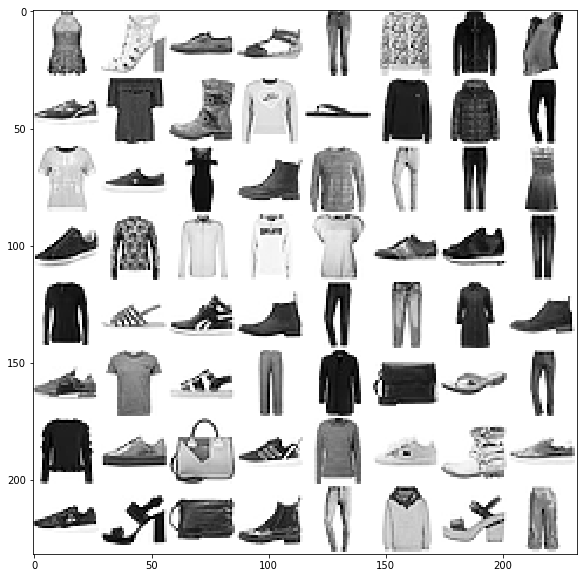

In [48]:
def plot_batch(batch, nslices=8):
    # Create one big image for plot
    img = np.zeros(((batch.shape[2] + 1) * nslices, (batch.shape[3] + 1) * nslices))
    for b in range(batch.shape[0]):
        row = int(b / nslices); col = int(b % nslices)
        r_p = row * batch.shape[2] + row; c_p = col * batch.shape[3] + col
        img[r_p:(r_p+batch.shape[2]),c_p:(c_p+batch.shape[3])] = torch.sum(batch[b], 0)
    im = plt.imshow(img, cmap='Greys', interpolation='nearest'),
    return im
# Select a random set of fixed data
fixed_batch, fixed_targets = next(iter(test_loader))
plt.figure(figsize=(10, 10))
plot_batch(fixed_batch);

Now based on our proposed implementation, the optimization aspects are defined in a very usual way

In [14]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Compute input dimensionality
nin = fixed_batch.shape[2] * fixed_batch.shape[3]
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)
# Create optimizer algorithm
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)

Now all that is left to do is train the model. We define here a `train_vae` function that we will reuse along the future implementations and variations of VAEs and flows. Note that this function is set to run for only a very few number of `epochs` and also most importantly, *only considers a subsample of the full dataset at each epoch*. This option is just here so that you can test the different models very quickly on any CPU or laptop.

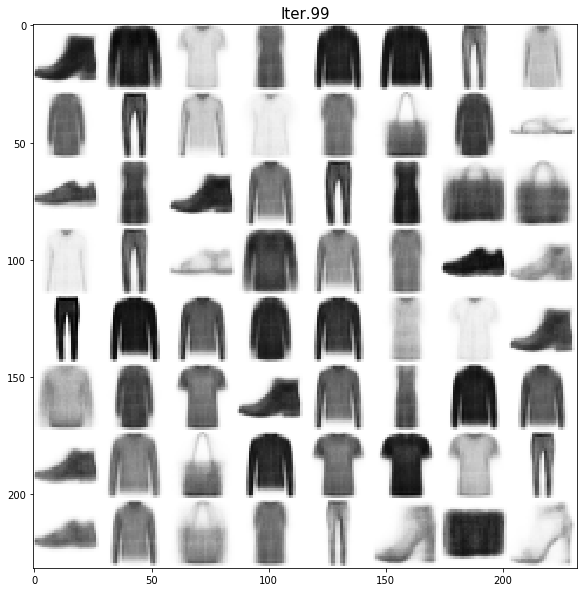

In [15]:
def train_vae(model, optimizer, scheduler, train_loader, fixed_batch, model_name='basic', epochs=50, plot_it=1, subsample=5000, flatten=True):
    # Losses curves
    losses = torch.zeros(epochs, 2)
    # Beta-warmup
    beta = 0
    # Plotting
    ims = []
    fig = plt.figure(figsize=(10, 10))
    # Main optimization loop
    for it in range(epochs):
        it_loss = torch.Tensor([2])
        # Update our beta
        beta = 1. * (it / float(epochs))
        n_batch = 0.
        # Evaluate loss and backprop
        for batch_idx, (x, _) in enumerate(train_loader):
            if (batch_idx * batch_size) > subsample:
                break
            # Flatten input data
            if (flatten):
                x = x.view(-1, nin)
            # Pass through VAE
            x_tilde, loss_latent = model(x)
            # Compute reconstruction loss
            loss_recons = reconstruction_loss(x_tilde, x, num_classes)
            # Evaluate loss and backprop
            loss = loss_recons + (beta * loss_latent)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            losses[it, 0] += loss_recons.item()
            losses[it, 1] += loss_latent.item()
            n_batch += 1.
        losses[it, :] /= n_batch
        if (it % plot_it == 0):
            # Encode our fixed batch
            samples = fixed_batch
            if (flatten):
                samples = fixed_batch.view(-1, nin)
            x_tilde, _ = model(samples)
            if (num_classes > 1):
                # Find largest class logit
                tmp = x_tilde.view(-1, num_classes, *x[0].shape[1:]).max(dim=1)[1]
                x_tilde = tmp.float() / (num_classes - 1.)
            ims.append(plot_batch(x_tilde.detach().view_as(fixed_batch)))
            plt.title('Iter.%i'%(it), fontsize=15);
    # Generate our animation
    anim = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    HTML(anim.to_html5_video())
    anim.save("vae_" + model_name + ".mp4")
    return losses
            
# Launch our optimization
losses_kld = train_vae(model, optimizer, scheduler, train_loader, fixed_batch, model_name='basic', epochs=100)

### Evaluating generative models

In order to evaluate our upcoming generative models, we will rely on the computation of the Negative Log-Likelihood. This code for the following `evaluate_nll_bpd` is inspired by the [Sylvester flow repository](https://github.com/riannevdberg/sylvester-flows)

In [25]:
from scipy.special import logsumexp

def evaluate_nll_bpd(data_loader, model, batch = 500, R = 5):
    model.eval()
    # Set of likelihood tests
    likelihood_test = []
    # Go through dataset
    for batch_idx, (x, _) in enumerate(data_loader):
        for j in range(x.shape[0]):
            a = []
            for r in range(0, R):
                cur_x = x[j].unsqueeze(0)
                # Repeat it as batch
                x = cur_x.expand(batch, *cur_x.size()[1:]).contiguous()
                x = x.view(batch, -1)
                x_tilde, kl_div = model(x)
                rec = reconstruction_loss(x_tilde, x, average=False)
                a_tmp = (rec + kl_div)
                a.append(- a_tmp.cpu().data.numpy())
            # calculate max
            a = np.asarray(a)
            a = np.reshape(a, (a.shape[0] * a.shape[1], 1))
            likelihood_x = logsumexp(a)
            likelihood_test.append(likelihood_x - np.log(len(a)))
    likelihood_test = np.array(likelihood_test)
    nll = - np.mean(likelihood_test)
    # Compute the bits per dim (but irrelevant for binary data)
    bpd = nll / (np.prod(nin) * np.log(2.))
    return nll, bpd

Now we can evaluate our VAE model more formally as follows.

Negative Log-Likelihood : 2.1232703443684082


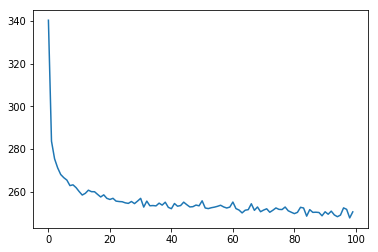

In [26]:
# Plot final loss
plt.figure()
plt.plot(losses_kld[:, 0].numpy());
# Evaluate log-likelihood and bits per dim
nll, _ = evaluate_nll_bpd(test_loader, model)
print('Negative Log-Likelihood : ' + str(nll))

### Limitations of VAEs

Although VAEs are extremely powerful tools, they still have some limitations. Here we list the three most important and known limitations (all of them are still debated and topics of active research). 
1. **Blurry reconstructions.** As can be witnessed directly in the results of the previous vanilla VAE implementation, the reconstructions appear to be blurry. The precise origin of this phenomenon is still debated, but the proposed explanation are
    1. The use of the KL regularization
    2. High variance regions of the latent space
    3. The reconstruction criterion (expectation)
    4. The use of simplistic latent distributions
2. **Posterior collapse.** The previous *blurry reconstructions* issue can be mitigated by using a more powerful decoder. However, relying on a decoder with a large capacity causes the phenomenon of *posterior collapse* where the latent space becomes useless. A nice intuitive explanation can be found [here](https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/)
3. **Simplistic Gaussian approximation**. In the derivation of the VAE objective, recall that the KL divergence term needs to be computed analytically. Therefore, this forces us to rely on quite simplistic families. However, the Gaussian family might be too simplistic to model real world data

In the present tutorial, we show how normalizing flows can be used to mostly solve the third limitation, while also adressing the two first problems. Indeed, we will see that normalizing flows also lead to sharper reconstructions and also act on preventing posterior collapse

<a id="vae"></a>
## Normalizing flows and VAEs

As we have seen in the previous section, one of the main limitations of VAEs is that they rely on a very simple family of approximations. In the original paper of Rezende [1], normalizing flows are used in order to complexify the posterior distribution of VAEs. 

### Flow-based free energy bound

If we parameterize the approximate posterior distribution with a flow of length $K$, $q_{\phi}(\mathbf{z}\vert\mathbf{x}) = q_K(\mathbf{z}_K)$, the free energy can be written as an expectation over the initial distribution $q_0(\mathbf{z})$

$$
\begin{align}
\mathcal{F}(\mathbf{x}) &= \mathbb{E}_{q_{\phi}(\mathbf{z}\vert\mathbf{x})}\left[
\text{log }q_{\phi}(\mathbf{z}\vert\mathbf{x}) − \text{log }p(\mathbf{x},\mathbf{z})\right]\\
&= \mathbb{E}_{q_0(z_0)}\left[\text{ln }q_{K}(\mathbf{z}_K) − \text{log }p(\mathbf{x},\mathbf{z}_K)\right] \\
&= \mathbb{E}_{q_0(z_0)}\left[\text{ln }q_{0}(\mathbf{z}_0)\right] − \mathbb{E}_{q_0(z_0)}\left[\text{log }p(\mathbf{x},\mathbf{z}_K)\right] - \mathbb{E}_{q_0(z_0)}\left[\sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right|\right] 
\end{align}
$$

Normalizing flows and this free energy bound can be used with any variational optimization scheme. For amortized variational inference, we construct an inference model using a deep neural network to build a mapping from the observations $\mathbf{x}$ to the parameters of the initial density $q_0 = \mathcal{N}(\mu, \sigma)$ as well as the parameters of the flow $\lambda$.

This allows us to write the complete optimization objective as
$$
\mathcal{L}_{\theta, \phi} = \mathbb{E}_{q_0} \big[ \log{ p_\theta (\mathbf{x|z_k}) } \big] + \mathbb{E}_{q_0}\left[\text{ln }q_{0}(\mathbf{z}_0) - \text{log }p(\mathbf{z}_K)\right] - \mathbb{E}_{q_0}\left[\sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right|\right] 
$$
   which can be optimized with stochastic gradient descent since $q_0$ is taken to be a Gaussian from which we can easily sample. However, now the final latent samples $\mathbf{z}_k$ will be drawn from a much more complex distribution. Also note that the previous KL criterion is replaced by two regularizations.

### Flows as posterior

In this first implementation of VAEs augmented with normalizing flows, we simply add a flow after the prior sampling. This is implemented in the following `VAENormalizingFlow` class. Note that the computation of different parts of the latent regularizations and the log determinants is performed explicitly here

In [27]:
class VAENormalizingFlow(VAE):
    
    def __init__(self, encoder, decoder, flow, encoder_dims, latent_dims):
        super(VAENormalizingFlow, self).__init__(encoder, decoder, encoder_dims, latent_dims)
        self.flow = flow

    def latent(self, x, z_params):
        n_batch = x.size(0)
        # Retrieve set of parameters
        mu, sigma = z_params
        # Re-parametrize a Normal distribution
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        # Obtain our first set of latent points
        z_0 = (sigma * q.sample((n_batch, ))) + mu
        # Complexify posterior with flows
        z_k, list_ladj = self.flow(z_0)
        # ln p(z_k) 
        log_p_zk = -0.5 * z_k * z_k
        # ln q(z_0)
        log_q_z0 = -0.5 * (sigma.log() + (z_0 - mu) * (z_0 - mu) * sigma.reciprocal())
        #  ln q(z_0) - ln p(z_k)
        logs = (log_q_z0 - log_p_zk).sum()
        # Add log determinants
        ladj = torch.cat(list_ladj)
        # ln q(z_0) - ln p(z_k) - sum[log det]
        logs -= torch.sum(ladj)
        return z_k, (logs / float(n_batch))

As we can see, this model behaves almost exactly like the Vanilla `VAE`. However, we now complexify the latent distribution with a given `flow` and then replace the KL divergence with the regularization based on the variational free energy. Note also that we rely on the implementation of `Flow` from the previous tutorial, where each flow optimizes its own parameters. Therefore, we can simply optimize this model similarily as the previous one.

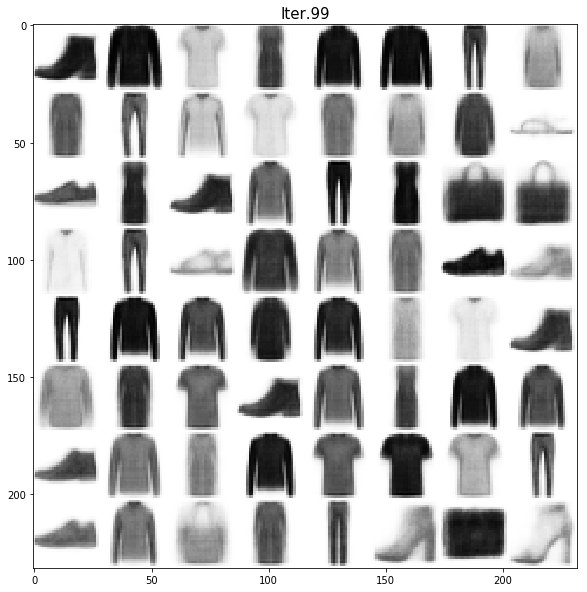

In [28]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Our MLP blocks
block_planar = [PlanarFlow]
# Create normalizing flow
flow = NormalizingFlow(dim=n_latent, blocks=block_planar, flow_length=16, density=distrib.MultivariateNormal(torch.zeros(n_latent), torch.eye(n_latent)))
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Create VAE with planar flows
model_flow = VAENormalizingFlow(encoder, decoder, flow, n_hidden, n_latent)
# Create optimizer algorithm
optimizer = optim.Adam(model_flow.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Launch our optimization
losses_flow = train_vae(model_flow, optimizer, scheduler, train_loader, fixed_batch, model_name='flow', epochs=100)

Now we can compare this improved VAE model with a normalizing flow to the original vanilla VAE on our log-likelihood criterion

Negative Log-Likelihood : 6.028702890602539


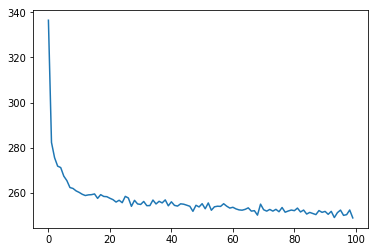

In [29]:
# Plot losses
plt.figure()
plt.plot(losses_flow[:, 0].numpy());
# Evaluate log-likelihood and bits per dim
nll, _ = evaluate_nll_bpd(test_loader, model_flow)
print('Negative Log-Likelihood : ' + str(nll))

### Amortized inference.

Although the previous implementation of `VAENormalizingFlow` seems to work well, the parameters of the flows are optimized separately from the encoder function. However, when performing amortized inference for normalizing flows, the flow parameters determine the final distribution. Therefore, the parameters should also be considered functions of the datapoint $\mathbf{x}$.

In the original paper [1] and most implementations, the parameters of the flows are directly produced by the encoder network. This allow to simplify the computations, while increasing the correlations of these parameters to the input.

To do so, we are going to slightly modify our base implementation of the global `NormalizingFlow`, by providing two supplementary functions
1. `set_parameters` allow to update the parameters of all the flows contained in this class
2. `n_parameters` returns the total number of parameters present in the sequence 

In [34]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        self.n_params = []
        for f in range(flow_length):
            for b_flow in blocks:
                cur_block = b_flow(dim)
                biject.append(cur_block)
                self.n_params.append(cur_block.n_parameters())
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []
        self.dim = dim

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det
        
    def n_parameters(self):
        return sum(self.n_params)
    
    def set_parameters(self, params):
        param_list = params.split(self.n_params, dim = 1)
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.bijectors[b].set_parameters(param_list[b])

Specifically for a given `Flow` operation (here we only modify the `PlanarFlow`, but this can be quite simply transposed), we are also adding two functions to obtain the number of parameters (summed dimensionnality of all tensors) and set their values. Here, we also change slightly the operation performed (compared to the previous tutorials), so that the flow parameters are actually *dependent on the input*. Therefore, the tensors will now be of dimensionality `batch_size x latent_dims`

In [35]:
class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = []
        self.scale = []
        self.bias = []
        self.dim = dim

    def _call(self, z):
        z = z.unsqueeze(2)
        f_z = torch.bmm(self.weight, z) + self.bias
        return (z + self.scale * torch.tanh(f_z)).squeeze(2)

    def log_abs_det_jacobian(self, z):
        z = z.unsqueeze(2)
        f_z = torch.bmm(self.weight, z) + self.bias
        psi = self.weight * (1 - torch.tanh(f_z) ** 2)
        det_grad = 1 + torch.bmm(psi, self.scale)
        return torch.log(det_grad.abs() + 1e-9)
    
    def set_parameters(self, p_list):
        self.weight = p_list[:, :self.dim].unsqueeze(1)
        self.scale = p_list[:, self.dim:self.dim*2].unsqueeze(2)
        self.bias = p_list[:, self.dim*2].unsqueeze(1).unsqueeze(2)
        
    def n_parameters(self):
        return 2 * self.dim + 1

Finally, we just need to make a few adjustments to the original class in order to account for this new way of optimizing the parameters. We simply add a separate encoder for the parameters (a linear layer), and also set the parameters of the `flow` before applying it to the samples.

In [36]:
class VAENormalizingFlow(VAE):
    
    def __init__(self, encoder, decoder, flow, encoder_dims, latent_dims):
        super(VAENormalizingFlow, self).__init__(encoder, decoder, encoder_dims, latent_dims)
        self.flow_enc = nn.Linear(encoder_dims, flow.n_parameters())
        self.flow = flow
        self.apply(self.init_parameters)
        self.flow_enc.weight.data.uniform_(-0.01, 0.01)
            
    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        flow_params = self.flow_enc(x)
        return mu, sigma, flow_params

    def latent(self, x, z_params):
        n_batch = x.size(0)
        # Split the encoded values to retrieve flow parameters
        mu, sigma, flow_params = z_params
        # Re-parametrize a Normal distribution
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        # Obtain our first set of latent points
        z_0 = (sigma * q.sample((n_batch, ))) + mu
        # Update flows parameters
        self.flow.set_parameters(flow_params)
        # Complexify posterior with flows
        z_k, list_ladj = self.flow(z_0)
        # ln p(z_k) 
        log_p_zk = -0.5 * z_k * z_k
        # ln q(z_0)
        log_q_z0 = -0.5 * (sigma.log() + (z_0 - mu) * (z_0 - mu) * sigma.reciprocal())
        #  ln q(z_0) - ln p(z_k)
        logs = (log_q_z0 - log_p_zk).sum()
        # Add log determinants
        ladj = torch.cat(list_ladj)
        # ln q(z_0) - ln p(z_k) - sum[log det]
        logs -= torch.sum(ladj)
        return z_k, (logs / float(n_batch))

Here, we re-optimize this modified `VAENormalizingFlow` class with the exact same procedure and hyper-parameters as the previous implementation

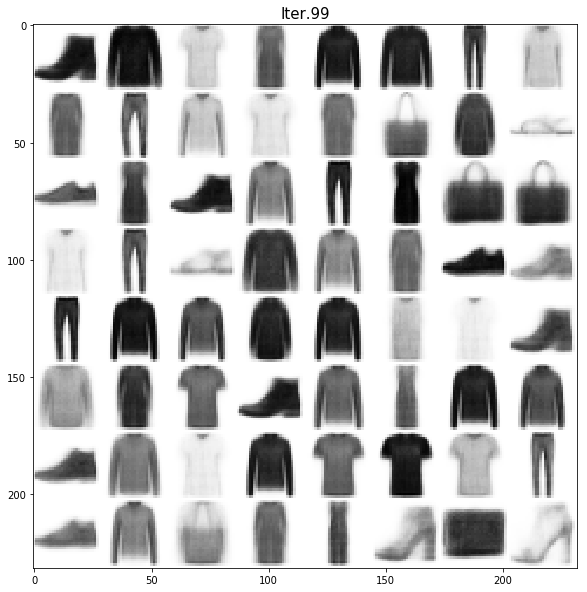

In [37]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Our MLP blocks
block_planar = [PlanarFlow]
# Create normalizing flow
flow = NormalizingFlow(dim=n_latent, blocks=block_planar, flow_length=16, density=distrib.MultivariateNormal(torch.zeros(n_latent), torch.eye(n_latent)))
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Create VAE with planar flows
model_flow_p = VAENormalizingFlow(encoder, decoder, flow, n_hidden, n_latent)
# Create optimizer algorithm
optimizer = optim.Adam(model_flow_p.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)
# Launch our optimization
losses_flow_param = train_vae(model_flow_p, optimizer, scheduler, train_loader, fixed_batch, model_name='flow_params', epochs=100)

Comparing this implementation regarding the log-likelihood and training curves, we have

Negative Log-Likelihood : 6.273616299168061


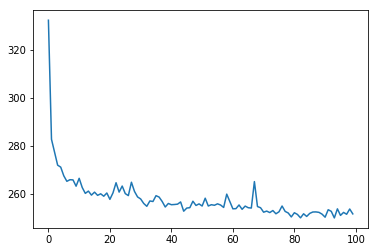

In [38]:
# Plot losses
plt.figure()
plt.plot(losses_flow_param[:, 0].numpy());
# Evaluate log-likelihood and bits per dim
nll, bpd = evaluate_nll_bpd(test_loader, model_flow_p)
print('Negative Log-Likelihood : ' + str(nll))

### Comparing the latent spaces of different models

One of the key aspect in the difference between the vanilla VAE and the VAE with normalizing flow is the treatment of the latent space. Hence a good way of assessing the impact of our flows is to check how the flow process the latent points. Here, we perform some visualisations of the latent spaces obtained 

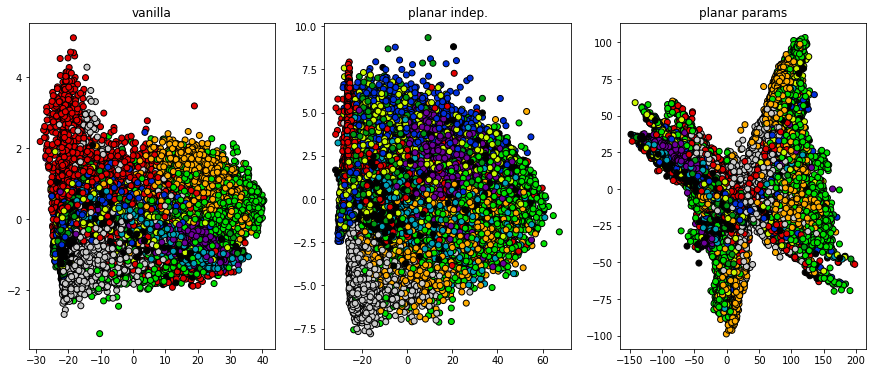

In [39]:
from sklearn import decomposition
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
models = {'vanilla':(model, ax1), 'planar indep.':(model_flow, ax2), 'planar params':(model_flow_p, ax3)}
for name, (cur_model, ax) in models.items():
    final_z = []
    final_classes = []
    for batch_idx, (x, c) in enumerate(train_loader):
        if (x.shape[0] != 64):
            break
        x = (x.view(x.shape[0], -1) * 2) - 1
        # Not exact but just consider mean for laziness
        cur_mu, cur_sig, *params = cur_model.encode(x)
        q = distrib.Normal(torch.zeros(cur_mu.shape[1]), torch.ones(cur_sig.shape[1]))
        cur_z = (cur_sig * q.sample((64, ))) + cur_mu
        if (hasattr(cur_model, 'flow')):
            if (name == 'planar params'):
                cur_model.flow.set_parameters(params[0])
            cur_z, _ = cur_model.flow(cur_z)
        final_z.append(cur_z.detach())
        final_classes.append(c)
    final_z = torch.cat(final_z)
    final_classes = torch.cat(final_classes)
    # Create PCA and apply it to our data
    pca = decomposition.PCA(n_components=2)
    pca.fit(final_z)
    z_pca = pca.transform(final_z)
    ax.scatter(z_pca[:, 0], z_pca[:, 1], c=final_classes, cmap=plt.cm.nipy_spectral, edgecolor='k')
    ax.set_title(name)

This concludes our implementation of normalizing flows with VAEs :)

<a id="improve"></a>
## Improving the quality of VAEs

As we discussed in the previous section, several known issues have been reported when using the vanilla VAE implementation. We listed some of the major issues as being
1. **Blurry reconstructions.** 
2. **Posterior collapse.**
3. **Simplistic Gaussian approximation**.

Here, we discuss some recent developments that were proposed in the VAE literature and simple adjustments that can be made to (at least partly) alleviate these issues. However, note that some more advanced proposals such as PixelVAE [5](#reference1) and VQ-VAE [6](#reference1) can lead to wider increases in quality

### Reducing the bluriness of reconstructions

In this tutorial, we relied on extremely simple decoder functions, to show how we could easily define VAEs and normalizing flows together. However, the capacity of the decoder obviously directly influences the quality of the final reconstruction. Therefore, we could address this issue naively by using deep networks and of course convolutional layers as we are currently dealing with images.

Here, we first introduce two layers based on *gated convolutions*. These will be our basis for constructing the encoder and decoder.

In [167]:
class GatedConv2d(nn.Module):
    def __init__(self, in_c, out_c, kernel, stride, pad, dilate=1, act=torch.relu):
        super(GatedConv2d, self).__init__()
        self.activation = act
        self.sigmoid = nn.Sigmoid()
        self.h = nn.Conv2d(in_c, out_c, kernel, stride, pad, dilate)
        self.g = nn.Conv2d(in_c, out_c, kernel, stride, pad, dilate)

    def forward(self, x):
        h = self.activation(self.h(x))
        g = self.sigmoid(self.g(x))
        return h * g

class GatedConvTranspose2d(nn.Module):
    def __init__(self, in_c, out_c, kernel, stride, pad, out_pad=0, dilate=1, act=torch.relu):
        super(GatedConvTranspose2d, self).__init__()
        self.activation = act
        self.sigmoid = nn.Sigmoid()
        self.h = nn.ConvTranspose2d(in_c, out_c, kernel, stride, pad, out_pad, dilation=dilate)
        self.g = nn.ConvTranspose2d(in_c, out_c, kernel, stride, pad, out_pad, dilation=dilate)

    def forward(self, x):
        h = self.activation(self.h(x))
        g = self.sigmoid(self.g(x))
        return h * g

Now we can construct a more complex encoder and decoder

In [23]:
def construct_encoder_decoder_complex(nin, n_latent = 16, n_hidden = 512, n_params = 0, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
                GatedConv2d(1, 32, 5, 1, 2),
                GatedConv2d(32, 32, 5, 2, 2),
                GatedConv2d(32, 64, 5, 1, 2),
                GatedConv2d(64, 64, 5, 2, 2),
                GatedConv2d(64, 64, 5, 1, 2),
                GatedConv2d(64, n_hidden, 7, 1, 0))
    # Decoder network
    decoder = nn.Sequential(
                GatedConvTranspose2d(n_latent, 64, 7, 1, 0),
                GatedConvTranspose2d(64, 64, 5, 1, 2),
                GatedConvTranspose2d(64, 32, 5, 2, 2, 1),
                GatedConvTranspose2d(32, 32, 5, 1, 2),
                GatedConvTranspose2d(32, 32, 5, 2, 2, 1),
                GatedConvTranspose2d(32, 32, 5, 1, 2),
                nn.Conv2d(32, 256, 5, 1, 2),
                nn.Conv2d(256, 1 * num_classes, 1, 1, 0))
    return encoder, decoder

### Preventing posterior collapse with Wasserstein-VAE-MMD (InfoVAE)

As we discussed earlier, the reason behind posterior collapse mostly relates to the KL divergence criterion (a nice intuitive explanation can be found [here](https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/). This can be mitigated by relying on a different criterion, such as regularizing the latent distribution by using the *Maximum Mean Discrepancy* (MMD) instead of the KL divergence. This model was independently proposed as the *InfoVAE* and later also as the *Wasserstein-VAE*.

Here we provide a simple implementation of the `InfoVAEMMD` class based on our previous implementations.

In [24]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1)
    y = y.unsqueeze(0)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) 

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

class InfoVAEMMD(VAE):
    
    def __init__(self, encoder, decoder):
        super(InfoVAEMMD, self).__init__(encoder, decoder)
        
    def latent(self, x, z_params):
        n_batch = x.size(0)
        mu, sigma = z_params.chunk(2, dim=1)
        # Re-parametrize
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        z = (sigma * q.sample((n_batch, ))) + mu
        # Sample from the z prior
        z_prior = q.sample((n_batch, ))
        # Compute MMD divergence
        mmd_dist = compute_mmd(z, z_prior)
        return z, mmd_dist

### Complexifying the posterior with flows

As this was the central topic of this tutorial, we will not go through the explanation again. However, as we will now be relying on convolutional layers instead of linear ones, we just need to make small changes in our encoding and decoding functions in order to control the shape of the different tensors. This is performed in the following class by simply adding two `view` operations in the `encode` and `decode` functions respectively. 

In [37]:
class VAENormalizingFlow(VAE):
    
    def __init__(self, encoder, decoder, flow, encoder_dims, latent_dims):
        super(VAENormalizingFlow, self).__init__(encoder, decoder, encoder_dims, latent_dims)
        self.flow_enc = nn.Linear(encoder_dims, flow.n_parameters())
        self.flow = flow
        self.apply(self.init_parameters)
            
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.shape[0], -1)
        mu = self.mu(x)
        sigma = self.sigma(x)
        flow_params = self.flow_enc(x)
        return mu, sigma, flow_params
            
    def decode(self, z):
        z = z.view(z.shape[0], z.shape[1], 1, 1)
        x_tilde = self.decoder(z)
        return x_tilde

    def latent(self, x, z_params):
        n_batch = x.size(0)
        # Split the encoded values to retrieve flow parameters
        mu, sigma, flow_params = z_params
        # Re-parametrize a Normal distribution
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        # Obtain our first set of latent points
        z_0 = (sigma * q.sample((n_batch, ))) + mu
        # Update flows parameters
        self.flow.set_parameters(flow_params)
        # Complexify posterior with flows
        z_k, list_ladj = self.flow(z_0)
        # ln p(z_k) 
        log_p_zk = torch.sum(-0.5 * z_k * z_k, dim=1)
        # ln q(z_0)  (not averaged)
        log_q_z0 = torch.sum(-0.5 * (sigma.log() + (z_0 - mu) * (z_0 - mu) * sigma.reciprocal()), dim=1)
        #  ln q(z_0) - ln p(z_k)
        logs = (log_q_z0 - log_p_zk).sum()
        # Add log determinants
        ladj = torch.cat(list_ladj, dim=1)
        # ln q(z_0) - ln p(z_k) - sum[log det]
        logs -= torch.sum(ladj)
        return z_k, (logs / float(n_batch))

### Putting it all together

Here we combine all these ideas (except for the MMD, which is not adequate as the flow definition already regularizes the latent space without the KL divergence) to perform a more advanced optimization of the dataset. Hence, we will rely on the complex encoder and decoder with gated convolutions, the multinomial loss and the normalizing flows in order to improve the overall quality of our reconstructions.

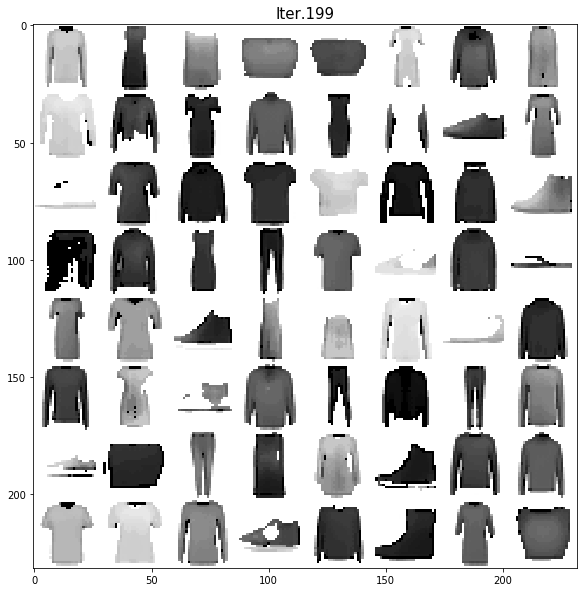

In [38]:
# Size of latent space
n_latent = 16
# Number of hidden units
n_hidden = 256
# Our MLP blocks
block_planar = [PlanarFlow]
# Create normalizing flow
flow = NormalizingFlow(dim=n_latent, blocks=block_planar, flow_length=16, density=distrib.MultivariateNormal(torch.zeros(n_latent), torch.eye(n_latent)))
# Rely on Bernoulli or multinomial
num_classes = 128
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder_complex(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Create VAE with planar flows
model_flow_p = VAENormalizingFlow(encoder, decoder, flow, n_hidden, n_latent)
# Create optimizer algorithm
optimizer = optim.Adam(model_flow_p.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Launch our optimization
losses_flow_param = train_vae(model_flow_p, optimizer, scheduler, train_loader, fixed_batch, model_name='flow_complex', epochs=200, flatten=False)

*NB*: It seems that the multinomial version have a hard time converging. Although I only let this run for 200 epochs and only for a subsampling of 5000 examples, it might need more time, but this might also come from a mistake somewhere in my code ... If you spot something odd please let me know :)

### References

<a id="reference1"></a>
[1] Rezende, Danilo Jimenez, and Shakir Mohamed. "Variational inference with normalizing flows." _arXiv preprint arXiv:1505.05770_ (2015). [link](http://arxiv.org/pdf/1505.05770)

[2] Kingma, Diederik P., Tim Salimans, and Max Welling. "Improving Variational Inference with Inverse Autoregressive Flow." _arXiv preprint arXiv:1606.04934_ (2016). [link](https://arxiv.org/abs/1606.04934)

[3] Kingma, D. P., & Welling, M. Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114. (2013). [link](https://arxiv.org/pdf/1312.6114)

[4] Rezende, D. J., Mohamed, S., & Wierstra, D. Stochastic backpropagation and approximate inference in deep generative models. arXiv preprint arXiv:1401.4082. (2014). [link](https://arxiv.org/pdf/1401.4082)

[5] Gulrajani, I., Kumar, K., Ahmed, F., Taiga, A. A., Visin, F., Vazquez, D., & Courville, A. (2016). Pixelvae: A latent variable model for natural images. arXiv preprint arXiv:1611.05013. [link](https://arxiv.org/pdf/1611.05013)

[6] Van den Oord, A., & Vinyals, O. (2017). Neural discrete representation learning. In NIPS 2017 (pp. 6306-6315). [link](http://papers.nips.cc/paper/7210-neural-discrete-representation-learning.pdf)

### Inspirations and resources

https://blog.evjang.com/2018/01/nf1.html  
https://github.com/ex4sperans/variational-inference-with-normalizing-flows  
https://akosiorek.github.io/ml/2018/04/03/norm_flows.html  
https://github.com/abdulfatir/normalizing-flows  
https://github.com/riannevdberg/sylvester-flows